# NLP Musixmatch
## NLP on top 20 lyrics data (athena's big dataframe), or on top 100 (newer dataframe)
### Cleans lyrics up (tokenizes, lowercases, removes stop words)
### Looks at repetitiveness as function of time
### Looks at bag of words vectors for different decades (including bi and tri grams)

In [1]:
# import things
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# Import BeautifulSoup into your workspace
from bs4 import BeautifulSoup  
import re
import string
import operator
from __future__ import division
import datetime
import nltk
#nltk.download()  # Download text data sets, including stop words
from nltk.corpus import stopwords # Import the stop word list
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

/Users/stephanie/anaconda3/envs/snakes/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Decide whether you want to look at Top20 data or Top100 data
max_rank = 100 # or 20 if you want
if max_rank==20:
    filename = 'Lyrics_1950-01-01-2015-01-01MaxRank20'
if max_rank==100:
    filename = 'Lyrics_1958-01-01-2017-01-01MaxRank100'

In [3]:
#read df from pickle file -- use Athena's large file
d = pd.read_pickle(filename)
d.head(3)
#read df from pickle file
hot100 = pd.read_pickle('./Billboard100DF')

In [4]:
#remind ourselves of what the column headers are
print 'fields in lyrics data:', list(d.columns.values)
print 'fields in hot100 data:', list(hot100.columns.values)

fields in lyrics data: ['artist string match score', 'artist_name', 'has_lyrics', 'hot100 SpotifyID', 'hot100 artist', 'hot100 track', 'lyrics_id', 'track_id', 'track_name', 'track_spotify_id', 'lyrics_copyright', 'lyrics_body', 'publisher_list', 'can_edit', 'writer_list', 'instrumental', 'verified', 'html_tracking_url', 'lyrics_language_description', 'locked', 'restricted', 'explicit', 'updated_time', 'script_tracking_url', 'action_requested', 'pixel_tracking_url', 'lyrics_language']
fields in hot100 data: ['Artist', 'Change', 'LastPos', 'PeakPos', 'Rank', 'SpotifyID', 'SpotifyLink', 'Title', 'Weeks', 'date']


In [12]:
# notice that the 20 lowest match scores are not true matches
fields_to_show = ['artist string match score','hot100 artist','artist_name', 'hot100 track', \
   'track_name']
d.sort_values('artist string match score').head(20)[fields_to_show]

,artist string match score,hot100 artist,artist_name,hot100 track,track_name
439,7.0,UB40,Bill Wyman's Rhythm Kings,Groovin',Groovin'
194,7.0,Paul Revere & The Raiders,Hum,"Like, Long Hair",I’d Like Your Hair Long
186,7.0,"Ecstasy, Passion & Pain",Snog,One Beautiful Day,"One Beautiful Day..., Part 1"
360,7.0,L.V.,Rihanna feat. Elephant Man,Throw Your Hands Up,Throw Your Hands Up
63,7.0,L.V.,Rihanna feat. Elephant Man,Throw Your Hands Up,Throw Your Hands Up
202,8.0,U2,Movie Sounds Unlimited,"Hold Me, Thrill Me, Kiss Me, Kill Me (From ""Ba...","Hold Me, Thrill Me, Kiss Me, Kill Me (From ""Ba..."
400,8.0,Kyu Sakamoto,Dick Curless,China Nights (Shina No Yoru),China Nights (Shina No Yoru)
292,8.0,Miguel Rios,Bobby Sherman,A Song Of Joy (Himno A La Alegria),A Song of Joy (Himno a La Alegria)
407,8.0,Arthur Prysock,Foxy Shazam,"It's Too Late, Baby Too Late",(It's) Too Late Baby
322,8.0,T.O.K.,A Tribe Called Quest,Footprints,Footprints


In [13]:
# convert certain columns to numeric data in billboard 100 df:
hot100['Weeks'] = pd.to_numeric(hot100['Weeks'])
hot100['Rank'] = pd.to_numeric(hot100['Rank'])
hot100['date'] = pd.to_datetime(hot100['date'])

In [14]:
# some clean up we have to do on billboard:
   
mess = 'Do You Know The Way To San Jos\xc3\x83\xc2\x83\xc3\x82\xc2\xa9'
clean = 'Do You Know The Way To San Jose'
hot100.ix[hot100.Title==mess,'Title']=clean
mess = 'Nel Blu Dipinto Di Blu (Volar\xc3\x83\xc2\x83\xc3\x82\xc2\xa9)'
clean = 'Nel Blu Dipinto Di Blu Volar'
hot100.ix[hot100.Title==mess,'Title']=clean
mess = 'Desir\xc3\x83\xc2\x83\xc3\x82\xc2\xa9e'
clean = 'Desire'
hot100.ix[hot100.Title==mess,'Title']=clean
mess = '\xc3\x83\xc2\x82\xc3\x82\xc2\xbfD\xc3\x83\xc2\x83\xc3\x82\xc2\xb2nde Est\xc3\x83\xc2\x83\xc3\x82\xc2\xa0 Santa Claus? (Where Is Santa Claus?)'
clean = 'Where Is Santa Claus?'
hot100.ix[hot100.Title==mess,'Title']=clean

#side note: the neil diamond one should really be "desiree"

In [22]:
# how many unique songs in the hot100 list?

# 2 cases, for using all 100 songs, and for using only top 20
if max_rank == 100:
    print 'Songs in hot100'
    hot100_artist_track = hot100[['Artist','Title']]
    print('# rows before de-dup: ', len(hot100_artist_track))
    print('# rows after de-dup: ', len(hot100_artist_track.drop_duplicates()))
    billboard_unique_count = len(hot100_artist_track.drop_duplicates())
if max_rank == 20:
    print 'Songs in hot100 top 20 only:'
    hot100_artist_track = hot100[['Artist','Title']][hot100['Rank']<21]
    print('# rows before de-dup: ', len(hot100_artist_track))
    print('# rows after de-dup: ', len(hot100_artist_track.drop_duplicates()))
    billboard_unique_count = len(hot100_artist_track.drop_duplicates())

Songs in hot100
('# rows before de-dup: ', 302142)
('# rows after de-dup: ', 27382)


('total df # songs = ', 27706)
('songs with score > 25 = ', 27119)
('songs with score > 50 = ', 20419)
('songs with score > 60 = ', 19637)
('songs with score > 80 = ', 18653)


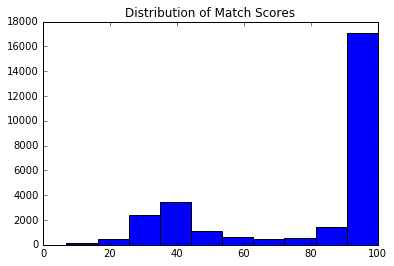

In [26]:
# get an ideo of how many songs we lose as we increase precision
print('total df # songs = ', len(d))
print('songs with score > 25 = ', len(d[d['artist string match score']>25]))
print('songs with score > 50 = ', len(d[d['artist string match score']>50]))
print('songs with score > 60 = ', len(d[d['artist string match score']>60]))
print('songs with score > 80 = ', len(d[d['artist string match score']>80]))
plt.hist(d['artist string match score'])
plt.title('Distribution of Match Scores')

In [32]:
# here you can play around with the cutoff score and see what the recall is:
cutoff_scores = [30, 40, 50, 60, 70, 80, 90]
for c in cutoff_scores:
    print 'cutoff score = ', c
    # add a column from the billboard df
    d_lyrics = d[d['artist string match score']>c]
    d_lyrics = d_lyrics[['hot100 artist','hot100 track','track_name','artist_name','track_spotify_id','lyrics_body']]
    #d_lyrics.head()
    # what is recall on the thing? 
    # note there are some duplicate entries in the total df (since we joined multiple years, and some songs are repeated
    # from year to year!)
    #print 'number songs in lyrics database: ',len(d_lyrics)
    #print 'number UNIQUE: ',len(d_lyrics.drop_duplicates())
    # recall on score > 60
    print 'recall :', len(d_lyrics.drop_duplicates())/float(billboard_unique_count)

cutoff score =  30
recall : 0.802242348988
cutoff score =  40
recall : 0.68176174129
cutoff score =  50
recall : 0.624059601198
cutoff score =  60
recall : 0.599919655248
cutoff score =  70
recall : 0.586114966036
cutoff score =  80
recall : 0.570484259733
cutoff score =  90
recall : 0.524651230736


### Now we have an idea of the increasing recall with decreasing precision. 

### Check the matches with scores near X to see that they are mostly true matches:
(play with the score X until you see mostly true matches)

In [39]:
X = 50
#check what the >X look like:
d[d['artist string match score']>X].sort_values('artist string match score').head(50)

,artist string match score,artist_name,has_lyrics,hot100 SpotifyID,hot100 artist,hot100 track,lyrics_id,track_id,track_name,track_spotify_id,...,html_tracking_url,lyrics_language_description,locked,restricted,explicit,updated_time,script_tracking_url,action_requested,pixel_tracking_url,lyrics_language
336,51.0,Tina Turner,1.0,26cEhbLg1r6Q49wAbZxE9F,Ike & Tina Turner Featuring Tina,River Deep-Mountain High,4349383.0,17022576.0,"River Deep, Mountain High",1xFe7CEQn9SZbFOsQZy3MR,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,0,2010-09-05T08:19:13Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
305,51.0,Mos Def feat. Talib Kweli,1.0,4C7Ss9bTPOWJMh3rarF1mN,Mos Def & Kweli Are Black Star,Definition,8114507.0,16409533.0,Definition,,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,1,2013-10-23T19:29:59Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
574,51.0,Three Days Grace,1.0,,The Dave Clark Five,Over And Over,12081215.0,5579500.0,Over and Over,6Dtq63g5m2sMIVd1Aw9ZDD,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,0,2015-09-04T20:48:59Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
338,51.0,MVP feat. Stagga Lee,1.0,,M.V.P. (Most Valuable Playas) Featuring Stagga...,"Roc Ya Body ""Mic Check 1,2""",7466215.0,16272159.0,"Roc Ya Body ""Mic Check 1, 2""",,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,1,2012-06-27T11:22:56Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
34,51.0,Bobby Day & The Satellites,1.0,53MkmSqmBa6s2b0Q9Zvg1C,Bobby Day,Rock-in Robin,6962274.0,17824443.0,Rock-In Robin,,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,1,2011-11-17T07:38:02Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
604,51.0,Bryan Adams & Melanie C,1.0,4zUf89GP3hRrDL4Bz1aMuO,Brenda & The Tabulations,When You're Gone,14069963.0,85310861.0,When You're Gone,7p9dd71JR2ucoAuO1Sy0VZ,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,1,2016-02-06T08:58:35Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
599,51.0,Paul Simon & Bob Dylan,1.0,35eHq3QNgBdbZZ5yPR9Edj,Simon & Garfunkel,The Sound Of Silence,8215947.0,15960723.0,The Sound of Silence,,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,0,2013-05-25T21:37:45Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
220,51.0,Seals & Crofts,1.0,,Seals & Crofts (Featuring Carolyn Willis),Get Closer,9671003.0,14609024.0,Get Closer,,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,1,0,2014-06-28T10:44:41Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
271,51.0,Olivia Newton-John and David Foster,1.0,,David Foster And Olivia Newton-John,The Best Of Me,5365710.0,89896305.0,The Best Of Me,4si6HSYvQMeRa7eSaL0kmA,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,0,2010-09-14T10:12:23Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
380,51.0,Jamie Foxx,1.0,3UNrtRxBBlWE70SjxnOo02,Jamie Foxx Featuring Ludacris,Unpredictable,6857716.0,33958489.0,Unpredictable,,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,1,2011-10-05T15:40:46Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en


### A cutoff of 50 gives mostly true matches, so let's use that and define our new dataframe for lyrics d_lyrics:

Note we've also simplified the number of fields in the data frame, maybe we can include more fields such as language later.

In [43]:
d_lyrics = d[d['artist string match score']>50]
d_lyrics = d_lyrics[['hot100 artist','hot100 track','track_name','artist_name','track_spotify_id','lyrics_body']]
d_lyrics.head()

,hot100 artist,hot100 track,track_name,artist_name,track_spotify_id,lyrics_body
0,Ricky Nelson,Poor Little Fool,Poor Little Fool,Ricky Nelson,6kGo2CzDxnPP6pxbqABZ7l,I used to play around with hearts\nThat hasten...
2,Bobby Darin,Splish Splash,Splish Splash,Bobby Darin,4RxtXFzUxQCOBAbggjN7mM,"Splish splash, I was taking a bath\nLong about..."
3,Elvis Presley With The Jordanaires,Hard Headed Woman,Hard Headed Woman,Elvis Presley & The Jordanaires,,Well a hard headed woman\nA soft hearted man\n...
4,Kalin Twins,When,When,Shania Twain,5AgF68czPZ2b46FnbelV6K,1... 2... NOW!\n\nIf elephants could fly I'd b...
6,The Coasters,Yakety Yak,Yakety Yak,The Coasters,3H8EafHcONmawrgbm6DB59,Take out the papers and the trash\nOr you don'...


In [41]:
d_lyrics[['lyrics_body']].iloc[1].values[0]

u"Splish splash, I was taking a bath\nLong about a Saturday night\nA rub dub, just relaxing in the tub\nThinking everything was alright\n\nWell, I stepped out the tub, put my feet on the floor\nI wrapped the towel around me\nAnd I opened the door, and then\nSplish, splash! I jumped back in the bath\nWell how was I to know there was a party going on\n\nThey was a-splishing and a-splashing, reelin' with the feelin'\n...\n\n******* This Lyrics is NOT for Commercial use *******"

In [44]:
# de-dupe lyrics data:
print '# songs lyrics data before de-dup ', len(d_lyrics)
d_lyrics = d_lyrics.drop_duplicates()
print '# songs lyrics data after de-dup ', len(d_lyrics)

# songs lyrics data before de-dup  20419
# songs lyrics data after de-dup  17088


### Let's add a date column to our lyrics dataframe. The block below gets all the dates when the song was in the top 100, and chooses the median date 
> Note: this cell takes a long time to run!

In [46]:
#first add the date column to the lyrics df
d_lyrics['date'] = ""
num_songs = len(d_lyrics)
for i in range(len(d_lyrics)):
    # find corresponding rows in hot100 data frame
    artist = d_lyrics.iloc[i]['hot100 artist']
    track = d_lyrics.iloc[i]['hot100 track']
    #print 'finding rows in hot100 df with artist,track = ', artist, ',', track
    match = hot100[(hot100['Artist']==artist) & (hot100['Title']==track)]
    if( (i+1)%400 == 0 ):
        print("Song %d of %d\n" % ( i+1, num_songs ))  
    #print len(match), ' rows found'
    #print match[['Artist','Title','date']]
    datelist = match.date.values
    median_date_index = int(np.floor(len(datelist)/2))
    date_lyrics = datelist[median_date_index]
    d_lyrics['date'].iloc[i]=date_lyrics

Song 400 of 17088

Song 800 of 17088

Song 1200 of 17088

Song 1600 of 17088

Song 2000 of 17088

Song 2400 of 17088

Song 2800 of 17088

Song 3200 of 17088

Song 3600 of 17088

Song 4000 of 17088

Song 4400 of 17088

Song 4800 of 17088

Song 5200 of 17088

Song 5600 of 17088

Song 6000 of 17088

Song 6400 of 17088

Song 6800 of 17088

Song 7200 of 17088

Song 7600 of 17088

Song 8000 of 17088

Song 8400 of 17088

Song 8800 of 17088

Song 9200 of 17088

Song 9600 of 17088

Song 10000 of 17088

Song 10400 of 17088

Song 10800 of 17088

Song 11200 of 17088

Song 11600 of 17088

Song 12000 of 17088

Song 12400 of 17088

Song 12800 of 17088

Song 13200 of 17088

Song 13600 of 17088

Song 14000 of 17088

Song 14400 of 17088

Song 14800 of 17088

Song 15200 of 17088

Song 15600 of 17088

Song 16000 of 17088

Song 16400 of 17088

Song 16800 of 17088



In [47]:
d_lyrics.tail(2)

,hot100 artist,hot100 track,track_name,artist_name,track_spotify_id,lyrics_body,date
244,Nicky Jam,Hasta El Amanecer,Hasta el Amanecer,Nicky Jam,4wFHfY9IILHLNwakPuFogD,"Como tú te llamas, yo no sé\nDe donde llegaste...",2016-06-17T17:00:00.000000000-0700
245,Chris Lane,Fix,Fix,Mark Lanegan,4EZqzJCmNtM413y9iPXYXO,Fix\nIt's true\nKeeps on rainin' baby\nAll cry...,2016-07-01T17:00:00.000000000-0700


### Some of the lyrics_body cells are empty due to copyright issues. Let's delete those rows:

In [48]:
#clean d_lyrics up -- if lyrics body is empty, remove it
print 'length d_lyrics before removing empty lyrics body:', len(d_lyrics)
print 'num empty songs:',len(d_lyrics[d_lyrics['lyrics_body']==''])
d_lyrics = d_lyrics[d_lyrics['lyrics_body'] != '']
print 'new length: ', len(d_lyrics)

length d_lyrics before removing empty lyrics body: 17088
num empty songs: 1220
new length:  15868


In [49]:
# the recall will decrease a bit:
# recall on score > 80 
print 'recall :', len(d_lyrics)/float(billboard_unique_count)

recall : 0.579504784165


### recall is pretty low, which we can improve on if we improve the GetLyrics algorithm

### for now just use this, work on getting more lyrics w/ better algorithm later!

## Begin Natural Language Processing Stuff!

In [50]:
print('The first lyric body is:')
print(d_lyrics[["lyrics_body"]].iloc[0].values[0])

The first lyric body is:
I used to play around with hearts
That hastened at my call
But when I met that little girl
I knew that I would fall

Poor little fool, oh yeah
I was a fool, uh huh
[(Oh oh, poor little fool)(I was a fool, oh yeah)]

She played around and teased me
With her carefree devil eyes
She'd hold me close and kiss me
But her heart was full of lies

Poor little fool, oh yeah
I was a fool, uh huh
...

******* This Lyrics is NOT for Commercial use *******


In [51]:
# Use regular expressions to do a find-and-replace
example1 = d_lyrics.lyrics_body.iloc[0]
letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                   # The pattern to replace it with
                      example1 )  # The text to search
print(letters_only)

I used to play around with hearts That hastened at my call But when I met that little girl I knew that I would fall  Poor little fool  oh yeah I was a fool  uh huh   Oh oh  poor little fool  I was a fool  oh yeah    She played around and teased me With her carefree devil eyes She d hold me close and kiss me But her heart was full of lies  Poor little fool  oh yeah I was a fool  uh huh              This Lyrics is NOT for Commercial use        


In [52]:
lower_case = letters_only.lower()        # Convert to lower case
words = lower_case.split()    
words = [str(w) for w in words]
print words

['i', 'used', 'to', 'play', 'around', 'with', 'hearts', 'that', 'hastened', 'at', 'my', 'call', 'but', 'when', 'i', 'met', 'that', 'little', 'girl', 'i', 'knew', 'that', 'i', 'would', 'fall', 'poor', 'little', 'fool', 'oh', 'yeah', 'i', 'was', 'a', 'fool', 'uh', 'huh', 'oh', 'oh', 'poor', 'little', 'fool', 'i', 'was', 'a', 'fool', 'oh', 'yeah', 'she', 'played', 'around', 'and', 'teased', 'me', 'with', 'her', 'carefree', 'devil', 'eyes', 'she', 'd', 'hold', 'me', 'close', 'and', 'kiss', 'me', 'but', 'her', 'heart', 'was', 'full', 'of', 'lies', 'poor', 'little', 'fool', 'oh', 'yeah', 'i', 'was', 'a', 'fool', 'uh', 'huh', 'this', 'lyrics', 'is', 'not', 'for', 'commercial', 'use']


In [53]:
#remove stopwords
# Remove stop words from "words"
words = [w for w in words if not w in stopwords.words("english")]
print(words)

['used', 'play', 'around', 'hearts', 'hastened', 'call', 'met', 'little', 'girl', 'knew', 'would', 'fall', 'poor', 'little', 'fool', 'oh', 'yeah', 'fool', 'uh', 'huh', 'oh', 'oh', 'poor', 'little', 'fool', 'fool', 'oh', 'yeah', 'played', 'around', 'teased', 'carefree', 'devil', 'eyes', 'hold', 'close', 'kiss', 'heart', 'full', 'lies', 'poor', 'little', 'fool', 'oh', 'yeah', 'fool', 'uh', 'huh', 'lyrics', 'commercial', 'use']


### Note we removed stopwords here, but that might not make sense for the analysis we're interested in. They are listed below. Notice something like "I love you" wouldn't make the cut.

In [54]:
print stopwords.words("english")

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

In [55]:
# note the last 3 words should be the same for all lyrics:
print 'last 3 words = lyrics, commercial, use ??'
words[-3:] == ['lyrics', 'commercial', 'use']

last 3 words = lyrics, commercial, use ??


True

In [56]:
#how to remove last 3 words:
words = words[:-3]

In [57]:
def lyrics_to_words( raw_lyrics ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    # lyrics_text = BeautifulSoup(raw_lyrics).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_lyrics) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()  
    words = [str(w) for w in words] #convert to normal string instead of unicode
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops] 
    assert (meaningful_words[-3:] == ['lyrics', 'commercial', 'use'])
    # remove last 3 words: (all songs should have these as last 3 unless copyright says no)
    meaningful_words = meaningful_words[:-3]
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   

In [58]:
clean_lyrics = lyrics_to_words( d_lyrics[["lyrics_body"]].iloc[0].values[0] )
print(clean_lyrics)

used play around hearts hastened call met little girl knew would fall poor little fool oh yeah fool uh huh oh oh poor little fool fool oh yeah played around teased carefree devil eyes hold close kiss heart full lies poor little fool oh yeah fool uh huh


In [59]:
clean_lyrics = lyrics_to_words( d_lyrics[["lyrics_body"]].iloc[1].values[0] )
print(clean_lyrics)

splish splash taking bath long saturday night rub dub relaxing tub thinking everything alright well stepped tub put feet floor wrapped towel around opened door splish splash jumped back bath well know party going splishing splashing reelin feelin


In [60]:
num_songs = d_lyrics["lyrics_body"].size
num_songs

15868

### Clean up all the lyrics, store cleaned lyrics as one big list (num_songs length)

In [61]:
# Get the number of reviews based on the dataframe column size
num_songs = d_lyrics["lyrics_body"].size

# Initialize an empty list to hold the clean reviews
clean_lyrics = []
# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
# change xrange to range for python 3
for i in xrange( 0, num_songs ):
    # Call our function for each one, and add the result to the list of
    if( (i+1)%400 == 0 ):
        print("Song %d of %d\n" % ( i+1, num_songs ))  
    # clean lyrics (one for each song)
    clean_lyrics.append( lyrics_to_words( d_lyrics[["lyrics_body"]].iloc[i].values[0] ) )


Song 400 of 15868

Song 800 of 15868

Song 1200 of 15868

Song 1600 of 15868

Song 2000 of 15868

Song 2400 of 15868

Song 2800 of 15868

Song 3200 of 15868

Song 3600 of 15868

Song 4000 of 15868

Song 4400 of 15868

Song 4800 of 15868

Song 5200 of 15868

Song 5600 of 15868

Song 6000 of 15868

Song 6400 of 15868

Song 6800 of 15868

Song 7200 of 15868

Song 7600 of 15868

Song 8000 of 15868

Song 8400 of 15868

Song 8800 of 15868

Song 9200 of 15868

Song 9600 of 15868

Song 10000 of 15868

Song 10400 of 15868

Song 10800 of 15868

Song 11200 of 15868

Song 11600 of 15868

Song 12000 of 15868

Song 12400 of 15868

Song 12800 of 15868

Song 13200 of 15868

Song 13600 of 15868

Song 14000 of 15868

Song 14400 of 15868

Song 14800 of 15868

Song 15200 of 15868

Song 15600 of 15868



### Put the cleaned lyrics into our lyrics dataframe (specify no_stopwords in case we want to add another column that includes stopwords

In [62]:
d_lyrics['lyrics_clean_no_stopwords'] = clean_lyrics

In [63]:
# see what happened to a few rows of lyrics, between raw and cleaned
d_lyrics[['lyrics_body','lyrics_clean_no_stopwords']].tail(5)

,lyrics_body,lyrics_clean_no_stopwords
241,"You hear a new song, it's your favorite\nPrett...",hear new song favorite pretty soon changing st...
242,It's two tickets to a concert\nIt's a Daytona ...,two tickets concert daytona airbrush shirt won...
243,"Could dress up, to get love\nBut guess what?\n...",could dress get love guess never gonna girl li...
244,"Como tú te llamas, yo no sé\nDe donde llegaste...",como te llamas yo de donde llegaste ni pregunt...
245,Fix\nIt's true\nKeeps on rainin' baby\nAll cry...,fix true keeps rainin baby crystalline word he...


## How has repetitiveness evolved over time?
> Define lexical diverisity for each song in the database as the number of unique words in that song divided by total number of words in the song. Lower diversity means higher repetitiveness.

In [64]:
# getting an idea of repetition in song lyrics:
test = clean_lyrics[0].split(" ")
print 'words in song:'
print test
print 'unique words in song:'
print set(test)
print 'song has ', len(test), ' words'
print 'but only ', len(set(test)), ' unique words'

# Lexical diversity or density...
# Lexical diversity is something like 
def lexical_diversity(song): 
    words_in_song = song.split(" ")
    return len(set(words_in_song)) / len(words_in_song)

lexical_diversity(clean_lyrics[0])
# note this would maybe be more meaningful if stop words weren't removed!

words in song:
['used', 'play', 'around', 'hearts', 'hastened', 'call', 'met', 'little', 'girl', 'knew', 'would', 'fall', 'poor', 'little', 'fool', 'oh', 'yeah', 'fool', 'uh', 'huh', 'oh', 'oh', 'poor', 'little', 'fool', 'fool', 'oh', 'yeah', 'played', 'around', 'teased', 'carefree', 'devil', 'eyes', 'hold', 'close', 'kiss', 'heart', 'full', 'lies', 'poor', 'little', 'fool', 'oh', 'yeah', 'fool', 'uh', 'huh']
unique words in song:
set(['fool', 'played', 'yeah', 'lies', 'full', 'close', 'hastened', 'eyes', 'girl', 'little', 'devil', 'would', 'call', 'poor', 'play', 'used', 'teased', 'around', 'knew', 'huh', 'carefree', 'met', 'kiss', 'fall', 'hold', 'oh', 'heart', 'uh', 'hearts'])
song has  48  words
but only  29  unique words


0.6041666666666666

In [65]:
#test running lexical diversity on the dataframe column values:
lexical_diversity(d_lyrics.lyrics_clean_no_stopwords.iloc[0])

0.6041666666666666

### Calculate lexical diversity for each row in the data frame and
### Add a column for lexical diversity to our data frame

In [66]:
d_lyrics['lex_diversity'] = d_lyrics.lyrics_clean_no_stopwords.map(lexical_diversity)

In [67]:
d_lyrics[['lex_diversity','date']].head(10)

,lex_diversity,date
0,0.604167,1958-09-13T00:00:00.000000000Z
2,0.868421,1958-09-06T00:00:00.000000000Z
3,0.574468,1958-09-06T00:00:00.000000000Z
4,1.000000,1958-09-06T00:00:00.000000000Z
6,0.962963,1958-08-30T00:00:00.000000000Z
8,0.600000,1958-09-13T00:00:00.000000000Z
11,0.857143,1958-09-27T00:00:00.000000000Z
12,0.444444,1958-08-30T00:00:00.000000000Z
13,0.760000,1958-09-13T00:00:00.000000000Z
14,0.875000,1958-08-23T00:00:00.000000000Z


In [53]:
# check how to sort by date..
d_lyrics.sort_values('date').date.values

array([numpy.datetime64('1958-08-23T00:00:00.000000000Z'),
       numpy.datetime64('1958-08-30T00:00:00.000000000Z'),
       numpy.datetime64('1958-08-30T00:00:00.000000000Z'), ...,
       numpy.datetime64('2016-02-12T16:00:00.000000000-0800'),
       numpy.datetime64('2016-03-11T16:00:00.000000000-0800'),
       numpy.datetime64('2016-03-25T17:00:00.000000000-0700')], dtype=object)

### Plot Lexical Diversity as a function of time:

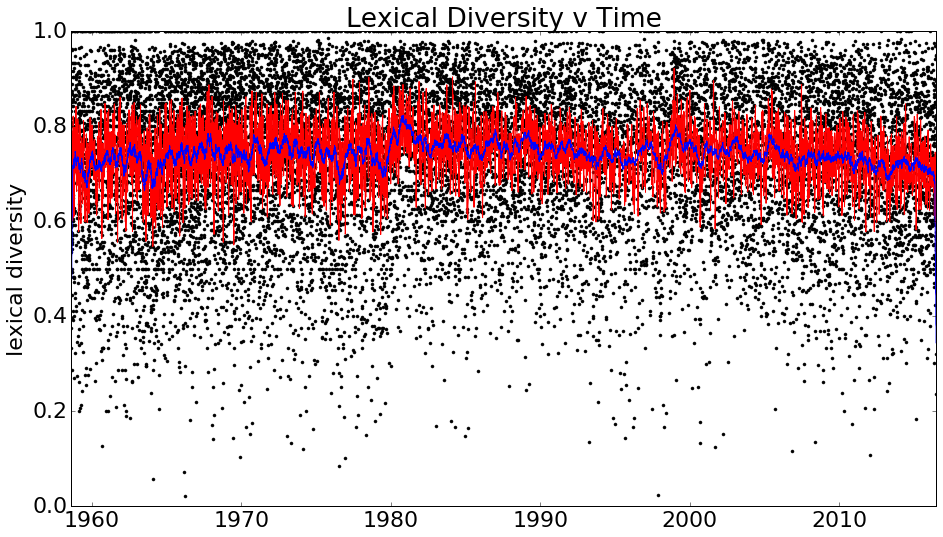

In [68]:
matplotlib.rcParams.update({'font.size': 22})
# what if look at a smoothed time series
#(want to take annual averages as well, but this is easy)
def window(size):
    return np.ones(size)/float(size)
times = d_lyrics.sort_values('date').date.values
vals = d_lyrics.sort_values('date').lex_diversity.values
plt.plot(times,vals,'k.')
plt.plot(times,np.convolve(vals,window(10),'same'),'r')
plt.plot(times,np.convolve(vals,window(100),'same'),'b')

plt.ylabel('lexical diversity')
fig = plt.gcf()
fig.set_size_inches(15.5, 8.5)
plt.title('Lexical Diversity v Time')

### ^^
>Maybe there is a decreasing trend in lexical diversity (increasing repetition) between the 1980s and present day?


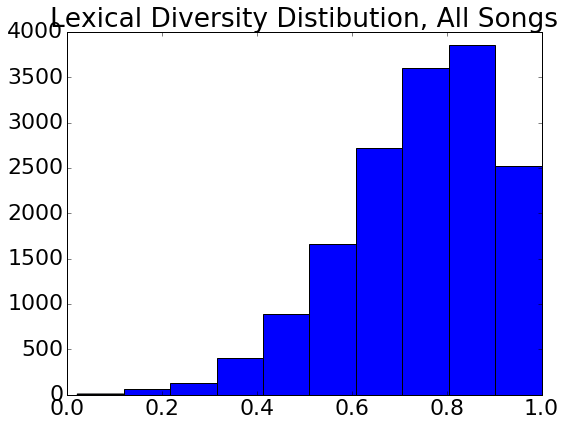

In [73]:
#can also plot a histogram...
plt.hist(vals)
plt.title('Lexical Diversity Distibution, All Songs')
fig = plt.gcf()
fig.set_size_inches(8.5, 6.5)

## Bag of Words Vectorization:

### The block below makes a bag of words array for each row in the d_lyrics data frame.
### Right now it is working with the column d_lyrics.lyrics_clean_no_stopwords
### In the future we could also have a column that includes stopwords, and we could see how the analysis changes when we include them (e.g. "I love you" might be a common tri-gram)
### ngram_range parameter allows us to include bi-grams and tri-grams if we want to.
### For tfidf:
> transformer = TfidfTransformer()
> tfidf = transformer.fit_transform(word_features)

In [74]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool. 

# Let's make a couple, one with just unigrams, one with just bigrams, 
# one with just tri-grams, and one with all 3
all3_vec = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000, \
                             ngram_range=(1,3)) 

unigram_vec = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000)
bigram_vec = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000, \
                             ngram_range=(2,2)) 
trigram_vec = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000, \
                             ngram_range=(3,3)) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
all3_features = all3_vec.fit_transform(d_lyrics.lyrics_clean_no_stopwords).toarray()
unigram_features = unigram_vec.fit_transform(d_lyrics.lyrics_clean_no_stopwords).toarray()
bigram_features = bigram_vec.fit_transform(d_lyrics.lyrics_clean_no_stopwords).toarray()
trigram_features = trigram_vec.fit_transform(d_lyrics.lyrics_clean_no_stopwords).toarray()
# Numpy arrays are easy to work with, so convert the result to an array
# omit the "toarray()" above if you want to preserve sparse format


print('done!')

done!


In [56]:
all3_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [57]:
#tfidf weighting -- another way to featurize the words, where rare words are given more weight.
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(all3_features)
tfidf.toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [75]:
def print_word_counts(vec, feats, n=10):
    # Take a look at the words in the vocabulary
    #n=10 #top 10 words if not input
    vocab = vec.get_feature_names()
    word_features = feats
    # Sum up the counts of each vocabulary word
    dist = np.sum(word_features, axis=0)
    count_dict = dict(zip(vocab, dist))
    #sort dict by counts to see most frequent words
    sorted_count_dict = sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True)
    #look at just the top 50 most frequent features
    print n, ' most frequent features:'
    print sorted_count_dict[:n]
    return sorted_count_dict[:n]

#### Print most common features (when uni- bi- and tri- are included)

In [76]:
foo = print_word_counts(all3_vec, all3_features, 20)

20  most frequent features:
[(u'love', 13430), (u'know', 10304), (u'like', 9821), (u'got', 8329), (u'oh', 8228), (u'baby', 7740), (u'get', 7434), (u'yeah', 6263), (u'one', 5634), (u'go', 5540), (u'let', 5497), (u'time', 5302), (u'see', 4869), (u'never', 4810), (u'girl', 4674), (u'make', 4631), (u'say', 4612), (u'want', 4497), (u'come', 4490), (u'way', 4483)]


#### Print most common bi-grams

In [77]:
foo = print_word_counts(bigram_vec, bigram_features, 20)

20  most frequent features:
[(u'oh oh', 2143), (u'yeah yeah', 1469), (u'la la', 1469), (u'na na', 963), (u'let go', 810), (u'love love', 764), (u'hey hey', 676), (u'ooh ooh', 653), (u'oh yeah', 639), (u'da da', 535), (u'baby baby', 451), (u'know know', 451), (u'feel like', 437), (u'doo doo', 429), (u'get get', 423), (u'every time', 391), (u'oh baby', 387), (u'ah ah', 386), (u'every day', 354), (u'know love', 351)]


#### Print most common tri-grams

In [78]:
foo = print_word_counts(trigram_vec, trigram_features, 20)

20  most frequent features:
[(u'oh oh oh', 1184), (u'la la la', 1182), (u'na na na', 787), (u'yeah yeah yeah', 736), (u'ooh ooh ooh', 397), (u'da da da', 367), (u'doo doo doo', 312), (u'hey hey hey', 302), (u'love love love', 242), (u'ah ah ah', 238), (u'get get get', 190), (u'ha ha ha', 181), (u'baby baby baby', 123), (u'know know know', 117), (u'ba ba ba', 115), (u'yeah oh yeah', 104), (u'come come come', 103), (u'whoa whoa whoa', 89), (u'oh yeah oh', 88), (u'let go let', 87)]


## How have popular words changed from decade to decade?

In [79]:
# Look at common words across different decades.
d_lyrics['date'] = pd.to_datetime(d_lyrics['date'])
#y = 1970 #decade of interest

for y in [1950, 1960, 1970, 1980, 1990, 2000, 2010]:
    print y, '\'s'
    start_date = datetime.date(year=y,month=1,day=1)
    end_date = datetime.date(year=y+10,month=1,day=1)
    subset = d_lyrics[(d_lyrics['date'] > start_date) & (d_lyrics['date'] < end_date) ]
    lyrics = subset.lyrics_clean_no_stopwords
    all3_features = all3_vec.fit_transform(lyrics).toarray()
    #unigram_features = unigram_vec.fit_transform(lyrics).toarray()
    #bigram_features = bigram_vec.fit_transform(lyrics).toarray()
    #trigram_features = trigram_vec.fit_transform(lyrics).toarray()
    foo = print_word_counts(all3_vec, all3_features)

1950 's
10  most frequent features:
[(u'love', 305), (u'oh', 215), (u'baby', 131), (u'know', 117), (u'got', 107), (u'never', 101), (u'well', 100), (u'like', 96), (u'little', 94), (u'come', 93)]
1960 's
10  most frequent features:
[(u'love', 2797), (u'baby', 1562), (u'oh', 1513), (u'know', 1377), (u'got', 1089), (u'yeah', 1062), (u'like', 942), (u'one', 866), (u'little', 851), (u'come', 829)]
1970 's
10  most frequent features:
[(u'love', 2629), (u'know', 1493), (u'oh', 1395), (u'baby', 1392), (u'got', 1351), (u'get', 1184), (u'like', 1141), (u'time', 935), (u'let', 909), (u'yeah', 881)]
1980 's
10  most frequent features:
[(u'love', 2651), (u'know', 1631), (u'oh', 1400), (u'like', 1217), (u'got', 1192), (u'baby', 1139), (u'time', 1040), (u'one', 991), (u'get', 964), (u'never', 849)]
1990 's
10  most frequent features:
[(u'love', 2163), (u'know', 1807), (u'like', 1775), (u'get', 1418), (u'baby', 1322), (u'got', 1279), (u'yeah', 1076), (u'oh', 1037), (u'one', 1033), (u'time', 984)]
2000 

### ^^ Perhaps "Love" has fallen out of fashion

### TO DO : Get the above info in a more usable form, to make a better visualization.

### Below I do the same as above for bigrams, then trigrams...

## How have common bigrams changed from decade to decade?

In [80]:
# Look at common words across different decades.
d_lyrics['date'] = pd.to_datetime(d_lyrics['date'])
#y = 1970 #decade of interest

for y in [1950, 1960, 1970, 1980, 1990, 2000, 2010]:
    print y, '\'s'
    start_date = datetime.date(year=y,month=1,day=1)
    end_date = datetime.date(year=y+10,month=1,day=1)
    subset = d_lyrics[(d_lyrics['date'] > start_date) & (d_lyrics['date'] < end_date) ]
    lyrics = subset.lyrics_clean_no_stopwords
    bigram_features = bigram_vec.fit_transform(lyrics).toarray()
    #unigram_features = unigram_vec.fit_transform(lyrics).toarray()
    #bigram_features = bigram_vec.fit_transform(lyrics).toarray()
    #trigram_features = trigram_vec.fit_transform(lyrics).toarray()
    foo = print_word_counts(bigram_vec, bigram_features)

1950 's
10  most frequent features:
[(u'oh oh', 63), (u'na na', 56), (u'la la', 55), (u'da da', 38), (u'yeah yeah', 37), (u'cha cha', 36), (u'love love', 29), (u'pretty girl', 27), (u'ooh ooh', 26), (u'bom bom', 23)]
1960 's
10  most frequent features:
[(u'yeah yeah', 358), (u'la la', 344), (u'oh oh', 291), (u'love love', 159), (u'oh yeah', 154), (u'hey hey', 138), (u'little girl', 121), (u'da da', 104), (u'ba ba', 102), (u'oop oop', 102)]
1970 's
10  most frequent features:
[(u'la la', 254), (u'yeah yeah', 207), (u'doo doo', 196), (u'oh oh', 190), (u'ooh ooh', 170), (u'love love', 165), (u'hey hey', 120), (u'oh yeah', 118), (u'get get', 116), (u'oh baby', 97)]
1980 's
10  most frequent features:
[(u'oh oh', 319), (u'yeah yeah', 213), (u'let go', 157), (u'ooh ooh', 156), (u'na na', 109), (u'love love', 108), (u'oh yeah', 80), (u'oh baby', 77), (u'know love', 75), (u'every time', 68)]
1990 's
10  most frequent features:
[(u'oh oh', 284), (u'yeah yeah', 214), (u'la la', 124), (u'let go',

## How have common tri-grams changed from decade to decade?

In [81]:
# Look at common words across different decades.
d_lyrics['date'] = pd.to_datetime(d_lyrics['date'])
#y = 1970 #decade of interest

for y in [1950, 1960, 1970, 1980, 1990, 2000, 2010]:
    print y, '\'s'
    start_date = datetime.date(year=y,month=1,day=1)
    end_date = datetime.date(year=y+10,month=1,day=1)
    subset = d_lyrics[(d_lyrics['date'] > start_date) & (d_lyrics['date'] < end_date) ]
    lyrics = subset.lyrics_clean_no_stopwords
    trigram_features = trigram_vec.fit_transform(lyrics).toarray()
    #unigram_features = unigram_vec.fit_transform(lyrics).toarray()
    #bigram_features = bigram_vec.fit_transform(lyrics).toarray()
    #trigram_features = trigram_vec.fit_transform(lyrics).toarray()
    foo = print_word_counts(trigram_vec, trigram_features)

1950 's
10  most frequent features:
[(u'na na na', 53), (u'la la la', 50), (u'da da da', 34), (u'oh oh oh', 30), (u'cha cha cha', 22), (u'yeah yeah yeah', 21), (u'bom bom bom', 19), (u'ooh ooh ooh', 19), (u'dooby doom dooby', 16), (u'pretty girl pretty', 15)]
1960 's
10  most frequent features:
[(u'la la la', 270), (u'yeah yeah yeah', 202), (u'oh oh oh', 139), (u'ah ah ah', 77), (u'oop oop oop', 76), (u'da da da', 76), (u'ba ba ba', 75), (u'na na na', 63), (u'ooh ooh ooh', 61), (u'hey hey hey', 58)]
1970 's
10  most frequent features:
[(u'la la la', 197), (u'doo doo doo', 152), (u'ooh ooh ooh', 112), (u'yeah yeah yeah', 93), (u'oh oh oh', 73), (u'get get get', 61), (u'na na na', 47), (u'love love love', 47), (u'ah ah ah', 45), (u'hey hey hey', 42)]
1980 's
10  most frequent features:
[(u'oh oh oh', 159), (u'yeah yeah yeah', 118), (u'na na na', 93), (u'ooh ooh ooh', 83), (u'love love love', 30), (u'ha ha ha', 27), (u'doo doo doo', 27), (u'whoa whoa whoa', 26), (u'la la la', 26), (u'ba b

## Sentiment analysis & TFIDF by decade:
### See new notebook: NLP_Sentiment_TFIDF

In [84]:
# Here I save the lyrics dataframe so we don't have to repeat the processing
name_to_save = 'CleanedLyricsDF_MaxRank_'+ str(max_rank)
d_lyrics.to_pickle(name_to_save)

# Also save the newer version of Billboard100 (with a few of the unicode error things cleaned up, and the date
# and integer columns converted to datetime and numeric types, from string)
hot100.to_pickle('Billboad100DF_cleaned')


## TO DO:

## Think about how to make the recommender! How do we define lyrical similarity (cosine?)? What featurization of lyrics (Uni,bi,tri-grams, TFIDF or raw counts?) How to combine BagOfWords + lexical density + sentiment into the recommender? Is sorting/nearest neighbor approach the best way to recommend? There's not a surefire way to know!

###Lower priority:
#### (1) Filter for language, add language and explicit flag to lyrics\_df (CleanedLyricsDF\_MaxRank\_100)
#### (2) Update analysis to include stop words as well as exclude them
#### (3) Look into stemming words
#### (4) Split contractions into their root words? 
#### 